# Introduction

The goal of this Kaggle challenge is to gain an understanding of various neural network architectures. The problem is a classic - digit recognition on the MNIST dataset, where we have hand-written digits that have been pixelated into 28x28 greyscale images, then flattened into a 1D array. We are trying to train a model to be able to properly recognize and assign the correct values to the digits. First, we implement a base neural network, using numpy, to show we understand the mechanics behind back-propagation. Then, we use a library to experiment with model architecture.

# Approach

## Base Numpy Implementation

The first step is to import all required libraries, as well as the three data sets we are working with. Next, we take the train targets, stored as a 1D array, and turn it into a 2D array that is storing probabilities - in this case, the probability of what the digit will be, from 0 to 9. We then transpose the x data sets so that each inner array is all features of a sample. And finally, we min-max normalize the x data sets so that the range of values is from 0 to 1. And for data inspection purposes, we have a piece of code to display each sample as an image.

In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt

#import datasets
training_set_y = np.genfromtxt("mnist_train_targets.csv", delimiter=",", dtype=float, skip_header=1)[:]
training_set_x = np.genfromtxt("mnist_train.csv", delimiter=",", dtype=float, skip_header=1)[:,:]
test_set_x = np.genfromtxt("mnist_test.csv", delimiter=",", dtype=float, skip_header=1)[:,:]

#turn 1D array into 2D probability array
Y = np.zeros((training_set_y.size, 10))
for i in range(training_set_y.size):
    num = int(training_set_y[i])
    Y[i, num] = 1

# transpose data sets
X = training_set_x.T
test_X = test_set_x.T

#min-max normalize data sets
for i in range(X[0].size):
    min = np.min(X[i])
    max = np.max(X[i])
    X[i] = (X[i] - min) / (max - min)

for i in range(test_X[0].size):
    min = np.min(test_X[i])
    max = np.max(test_X[i])
    test_X[i] = (test_X[i] - min) / (max - min)

# display digit image
plt.imshow(X[0].reshape(28, 28), cmap='gray')
plt.show()

Here we define a bunch of methods used in the base implementation. First is the output method, which is used to reshape the predictions and output them into a csv file that follows the format the Kaggle challenge expects of its submissions. Next, we have activation functions ReLU, sigmoid, and softmax, with both their forward and derivative versions. We then have a method for completing a single forward pass in the neural network. Next, we have two weight initialization functions. And finally, we have a function for calculating the binary cross entropy loss, as that's what our loss is.

In [ ]:
def output(results):
    # reshape to tall
    results = results.reshape((-1, 1))

    #create csv in correct format
    with open("output.csv", 'w', newline='') as csvfile:
        outputwriter = csv.writer(csvfile, quotechar='"', delimiter=",")
        outputwriter.writerow(['Id'] + ['Expected'])
        for n in range(results.size):
            outputwriter.writerow([str(int(n+1))] + [str(int(results[n]))])

def ReLU (y):
    z = np.where(y<0, 0, y)
    return z

def dReLU (z):
    y = np.where(z<=0, 0, 1)
    return y

def softmax(y):
    return np.exp(y) / sum(np.exp(y))

def d_softmax(z):
    gz = softmax(z)
    side_length = z.size
    deriv = np.zeros((side_length, side_length))
    for i in range(side_length):
        for j in range(side_length):
            if (i == j):
                deriv[i,j] = gz[i] * (1 - gz[i])
            else:
                deriv[i,j] = -gz[i] * gz[j]
    result = np.zeros(side_length)
    for i in range(side_length):
        result[i] = np.sum(deriv[i])
    return result

def sigmoid(y):
    return 1 / (1 + np.exp(-y))

def d_sigmoid(z):
    return z * (1 - z)

def forward(x, w, b, funct):
    y = np.dot(x, w) + b
    if funct == "ReLU":
        return ReLU(y)
    elif funct == "Sigmoid":
        return sigmoid(y)
    elif funct == "Softmax":
        return softmax(y)
    else:
        return y

def glorot_uniform(size_in, size_out, random_state=12345):
    rng = np.random.default_rng(random_state)
    limit = np.sqrt(6. / (size_in + size_out))
    return rng.uniform(low=-limit, high=limit, size=(size_in, size_out)).astype('float32')

def he_init(size_in, size_out, random_state=12345):
    rng = np.random.default_rng(random_state)
    std_dev = np.sqrt(2 / size_in)
    weights = rng.normal(loc=0.0, scale=std_dev, size=(size_in, size_out))
    return weights

def binary_cross_entropy(y_true, y_pred):
    eps = 1e-7
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

Now we have the actual neural network itself. It is set up with two hidden layers with ReLU activations, then a softmax activation on the output. There's also an in-built accuracy counter, to see how the network's accuracy improves from epoch to epoch.

In [ ]:
def deep_nn(X, y, hidden_size_1, hidden_size_2, num_epochs=100, learning_rate=0.001, random_state=12345) :
    if random_state is not None:
        rng = np.random.default_rng(random_state)
    else:
        rng = np.random.default_rng()
    w1 = he_init(X[0].size, hidden_size_1, random_state)
    w2 = he_init(hidden_size_1, hidden_size_2, random_state)
    wn = he_init(hidden_size_2, 10, random_state)
    b1 = np.zeros(hidden_size_1)
    b2 = np.zeros(hidden_size_2)
    bn = np.zeros(y[0].size)
    stochastic_order = np.arange(0, X.T[0].size)
    for epoch in range(num_epochs):
        correct_count = 0
        rng.shuffle(stochastic_order)
        for i in stochastic_order:

            z1 = forward(X[i,], w1, b1, "ReLU")
            z2 = forward(z1, w2, b2, "ReLU")
            output = forward(z2, wn, bn, "Softmax")

            if np.argmax(output) == np.argmax(y[i]):
                correct_count += 1
            error = binary_cross_entropy(y[i], output)
            dyn = error * d_softmax(output)
            dy2 = np.dot(dyn, wn.T) * dReLU(z2)
            dy1 = np.dot(dy2, w2.T) * dReLU(z1)
            
            wn = wn + (learning_rate * np.outer(z2, dyn))
            bn = bn + (learning_rate * dyn)
            w2 = w2 + (learning_rate * np.outer(z1, dy2))
            b2 = b2 + (learning_rate * dy2)
            w1 = w1 + (learning_rate * np.outer(X[i,], dy1))
            b1 = b1 + (learning_rate * dy1)
        pct_accurate = round(correct_count/stochastic_order.size * 100, 2)
        print('Epoch ' + str(epoch) + ' done. Accuracy = ' + str(pct_accurate) + "%.")
    return w1, w2, wn, b1, b2, bn

Finally, we have the prediction portion of the base implementation. First, we run the neural network to generate our set of weights and biases. Then, we use those weights and biases our network has calculated, to predict what our test set's digits are, then create an array with the highest probability prediction for each sample, and output them using the output function above.

My implementation was never able to converge - I believe it could given enough time and hyperparameter tuning, but that would have taken time, which is compounded by the relative slowness of my implementation.

In [ ]:
w1, w2, wn, b1, b2, bn = deep_nn(X, Y, 250, 50, num_epochs=10)

z1 = forward(test_X, w1, b1, "ReLU")
z2 = forward(z1, w2, b2, "ReLU")
# z3 = forward(z2, w3, b3, "ReLU")
probs = forward(z2, wn, bn, "Softmax")

results = np.zeros(test_X[:,0].size)
for i in range(test_X[:,0].size):
    results[i] = np.argmax(probs[i])

output(results)

## PyTorch Implementation

Next, we created an implementation using PyTorch. Our first step is to import everything we need. We then set the random number seed for torch, to ensure reproducible results. Then we import and prepare the data sets for training. We transpose the x sets, min max scale them, then turn them from arrays into PyTorch tensors. We also change to specific data types to ensure everything works smoothly. We then create a dataset including both the x and y training values, split it into train and test datasets for cross validation, then load those datasets into dataloaders to make use of PyTorch's auto batching features. Finally, we define the device we will be using - for simplicity's sake, everything will be done on the cpu, rather than utilizing CUDA for graphics card parallelization.

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import csv
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(12345)

training_set_y = np.genfromtxt("mnist_train_targets.csv", delimiter=",", dtype=float, skip_header=1)[:]
training_set_x = np.genfromtxt("mnist_train.csv", delimiter=",", dtype=float, skip_header=1)[:,:]
test_set_x = np.genfromtxt("mnist_test.csv", delimiter=",", dtype=float, skip_header=1)[:,:]

X = training_set_x.T
test_X = test_set_x.T

for i in range(X[0].size):
    min = np.min(X[i])
    max = np.max(X[i])
    X[i] = (X[i] - min) / (max - min)

for i in range(test_X[0].size):
    min = np.min(test_X[i])
    max = np.max(test_X[i])
    test_X[i] = (test_X[i] - min) / (max - min)

x_train = torch.from_numpy(X)
x_train = x_train.to(torch.float32)
y_train = torch.from_numpy(training_set_y)
y_train = y_train.to(torch.long)
x_valid = torch.from_numpy(test_X)
x_valid = x_valid.to(torch.float32)

x_ds = TensorDataset(x_train, y_train)

train_ds, test_ds = random_split(x_ds, [0.7, 0.3])
train_dl = DataLoader(train_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)

device = "cpu"

Next, we define the neural network, loss functions, and optimizer. Our base architecture is two hidden layers, both with ReLU activation, then a softmax activation on the output. We are using cross entropy loss as our loss function, and Adam for our optimizer. For doing architecture experimentation in the results section, we will simply be adding various things to this base sequence of layers, be it dropout layers, group or layer norms, or other architectural things we wish to test.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

model = NeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Next, we have our train and test methods. The train method is a single epoch of training, with feed forward and backpropagation, and the test method is simply a forward feed on whatever it is given, followed by summing up both the average loss and the percentage of correct predictions.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Next, we have the loop that takes us through our epochs, giving us updates on how the model is doing predicting the test set we created. Finally, it uses the complete model to predict our actual test dataset, then outputs it using the same method we used in our numpy implementation.

In [ ]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, model, loss_fn, optimizer)
    test(test_dl, model, loss_fn)
print("Done!")

with torch.no_grad():
    pred = model(x_valid)
    pred = pred.detach().numpy()

results = np.zeros(test_X[:,0].size)
for i in range(test_X[:,0].size):
    results[i] = np.argmax(pred[i])

output(results)

# Results

For our results, we will be examining the graph of accuracy over each epoch, to examine how accurate it got, and how quickly it got that accurate. To keep things consistent, we kept all hyperparameters the same, and just changed the neural network architecture. Our hyperparameters were at: 128 and 32 for the size of the two hidden layers, with a learning rate of 0.001, and all other Adam hyperparameters left at their defaults. We ran each through 50 epochs. First, we have our base architecture, shown in the previous section:

![base architecture.png](<attachment:base architecture.png>)

Figure 1: Accuracy Over Training Epochs, base architecture.

As you can see, we hit 90% accurate after 12 epochs, then found a local minima that kept us around the 90%-92% mark.

Next, we tried adding a dropout layer (with a p value of 0.5) on our inputs:

![dropout layer at front.png](<attachment:dropout layer at front.png>)

Figure 2: Accuracy Over Training Epochs, dropout layer at start of neural network architecture.

This took longer to train and did not get as accurate as our base architecture. So a dropout layer on its own is not an improvement.

Next, we added a layer norm layer after the first ReLU hidden layer:

![layer norm after first hidden layer.png](<attachment:layer norm after first hidden layer.png>)

Figure 3: Accuracy Over Training Epochs, layer norm layer after first hidden layer.

Now this is improvement! Our accuracy was in the 90s after a single epoch, and climbed to above 97% after only 14 epochs! This is obviously a winner for us.

Now let's see how a batch norm improves things. We'll add it at the same spot we added the layer norm:

![batch norm after first hidden layer.png](<attachment:batch norm after first hidden layer.png>)

Figure 4: Accuracy Over Training Epochs, batch norm layer after first hidden layer.

This is also an improvement over our base architecture, but it was less improvement than the layer norm layer.

Now, how about we try multiple added layers! What if we combine the dropout layer with the norm layers? Let's start with dropout and batch norm, at the same places in the architecture as they were in their separate tests:

![dropout and batch.png](<attachment:dropout and batch.png>)

Figure 5: Accuracy Over Training Epochs, dropout layer at start of neural network, batch norm layer after first hidden layer.

Adding this dropout layer is an improvement over just having the batch norm layer, but it doesn't manage to get as accurate as having the layer norm.

Now let's see what happens if we combine the dropout layer and the layer norm layer:

![dropout and layer.png](<attachment:dropout and layer.png>)

Figure 6: Accuracy Over Training Epochs, dropout layer at start of neural network, layer norm layer after first hidden layer.

This is also an improvement over having the layer norm on its own, and it is the best starting point we can have. So we decided to use this architecture as our starting point for hyperparameter tuning. First, we got a Kaggle score for our pre-hyperparameter tuning model, which achieved a public score of 0.97966. Then, we did hyperparameter tuning, starting with the size of hidden layer 1, then hidden layer 2, then learning rate, then finally dropout layer chance to dropout. At the end of our tuning, we found that the best parameters we could use were: hidden layer 1 size at 160, hidden layer 2 size at 45, learning rate at 0.001, and dropout layer p at 0.1.

However, after all of this hyperparameter tuning, I submitted the results of this model to Kaggle, and got a public score of 0.97766, which is lower than the model before hyperparameter tuning. This means that the tuning over-fitted our test set, and was less generalizable than our initial model. I plan on submitting both as my two best scores, and finding out if the tuned model performs better on the private score.
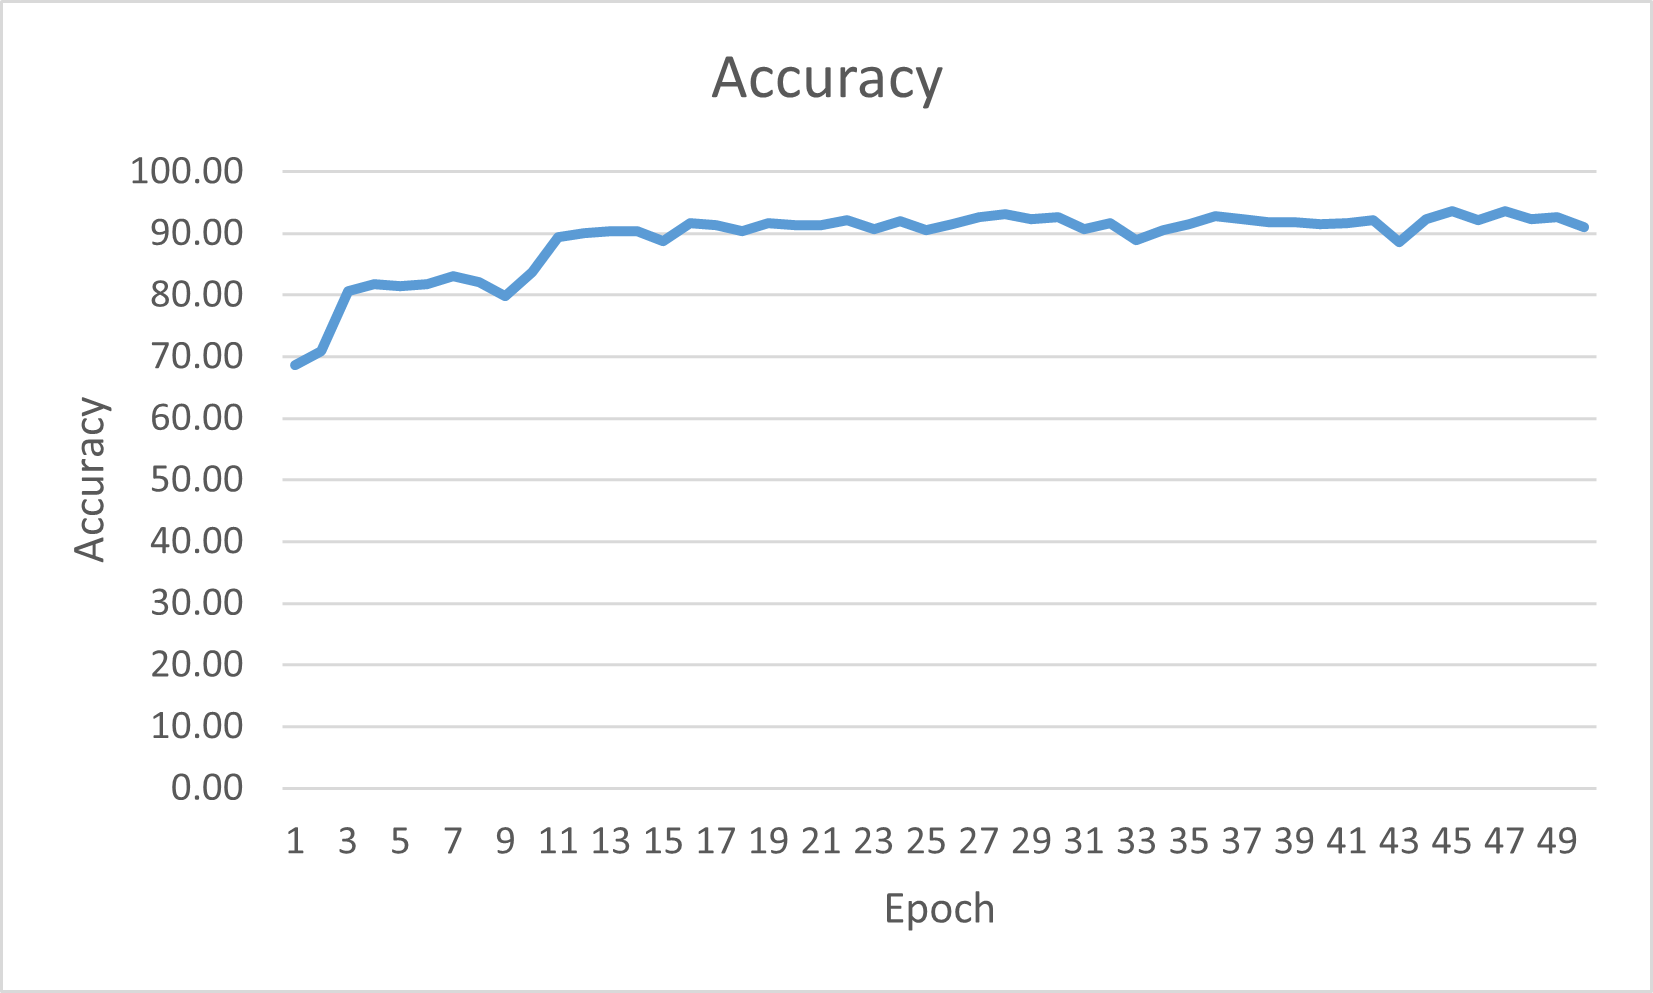
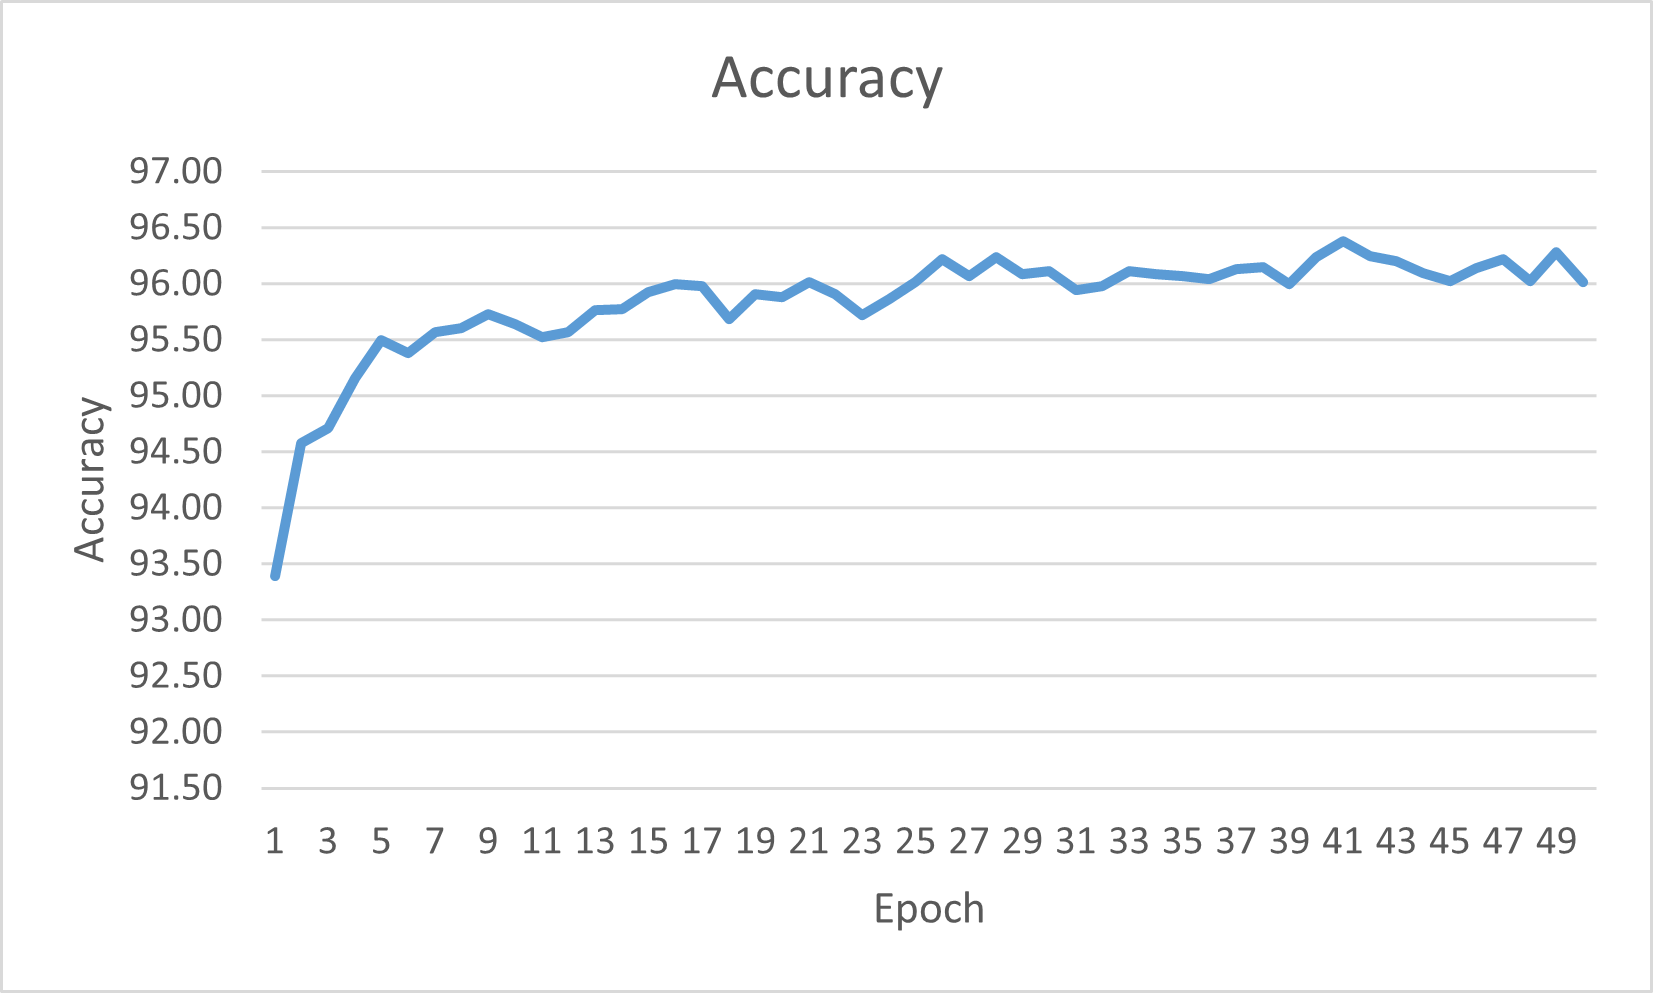
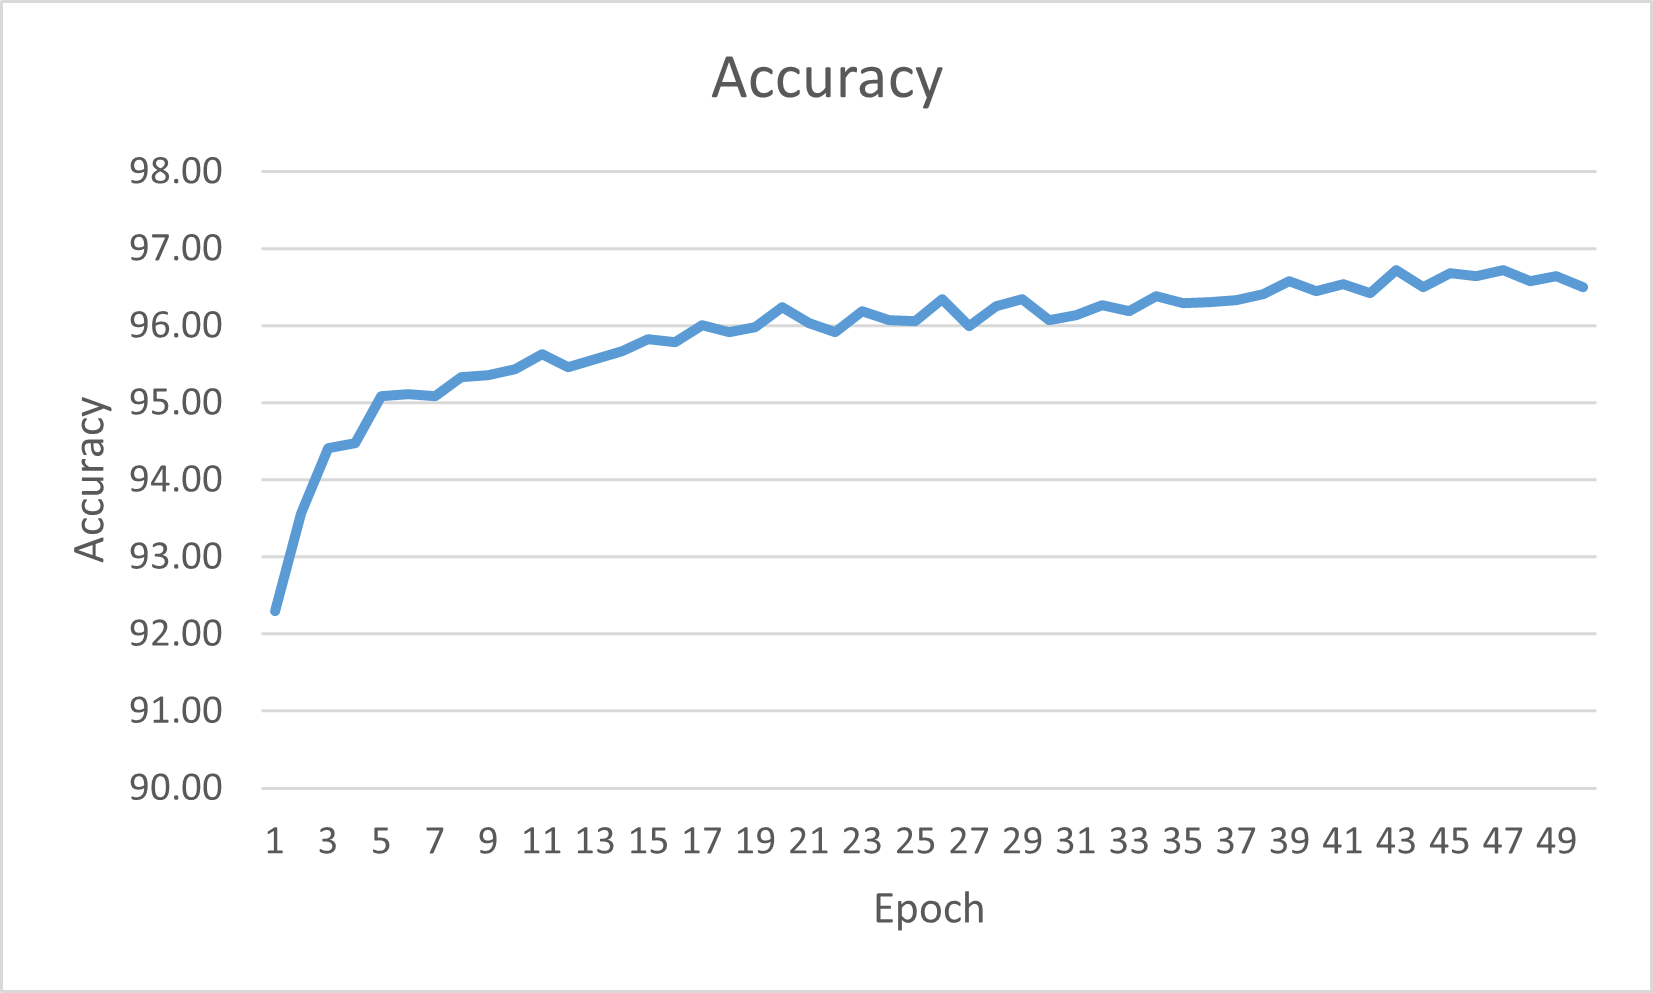
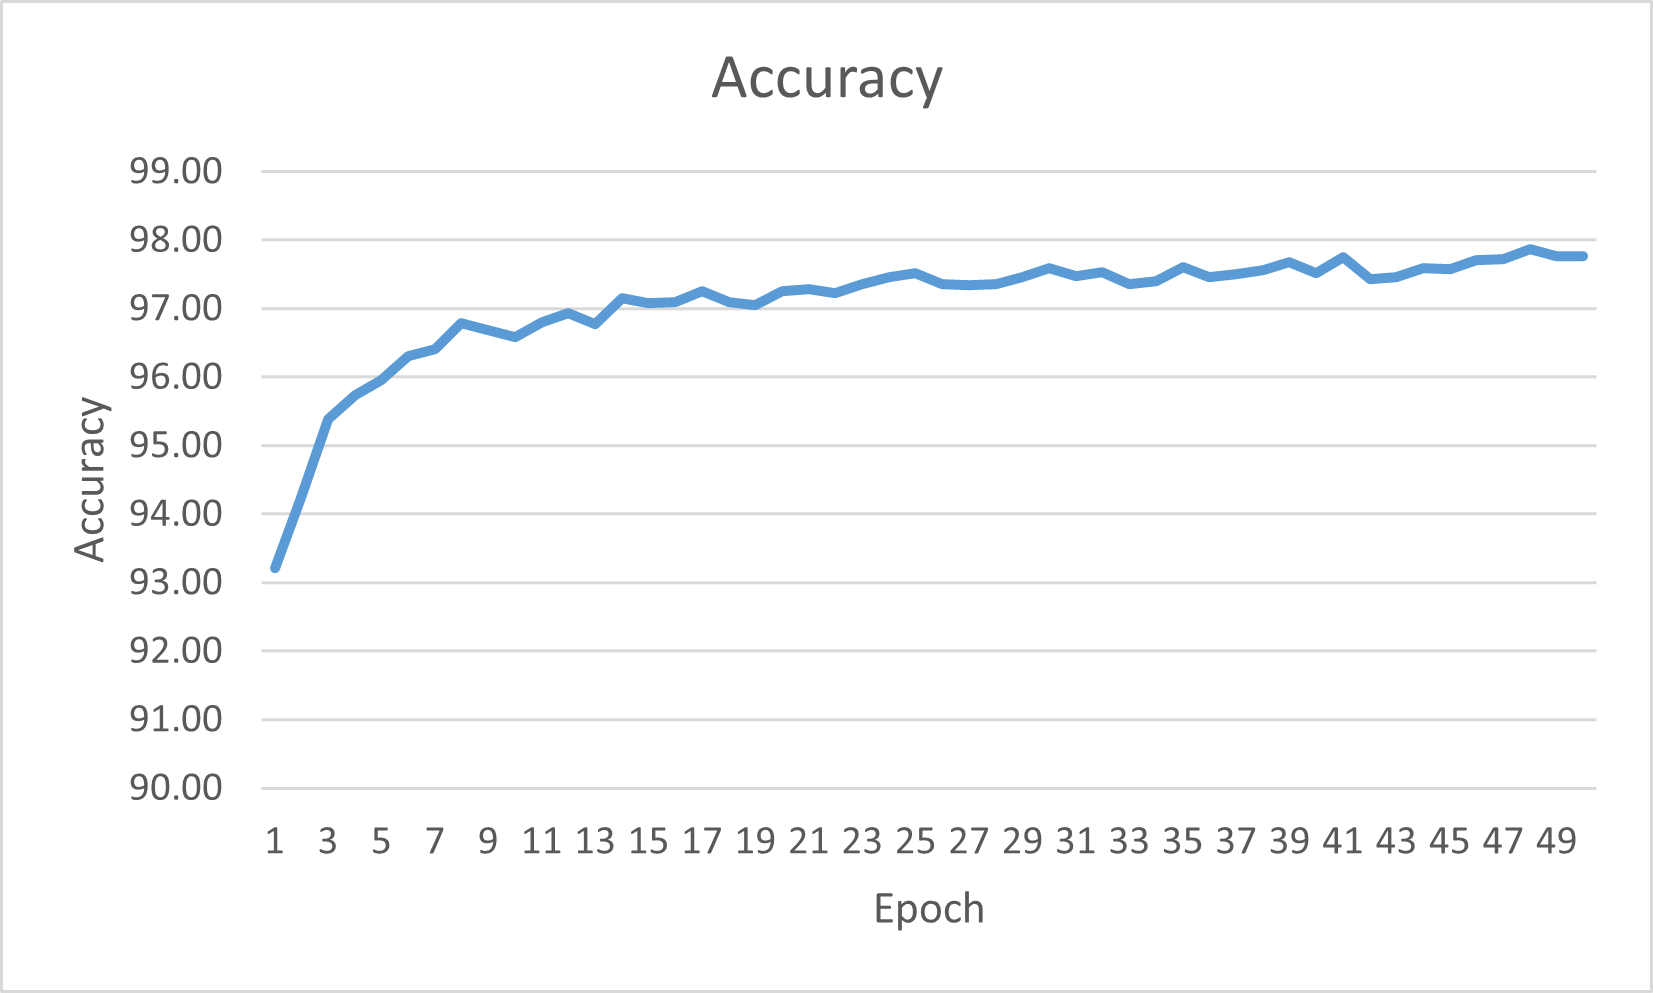
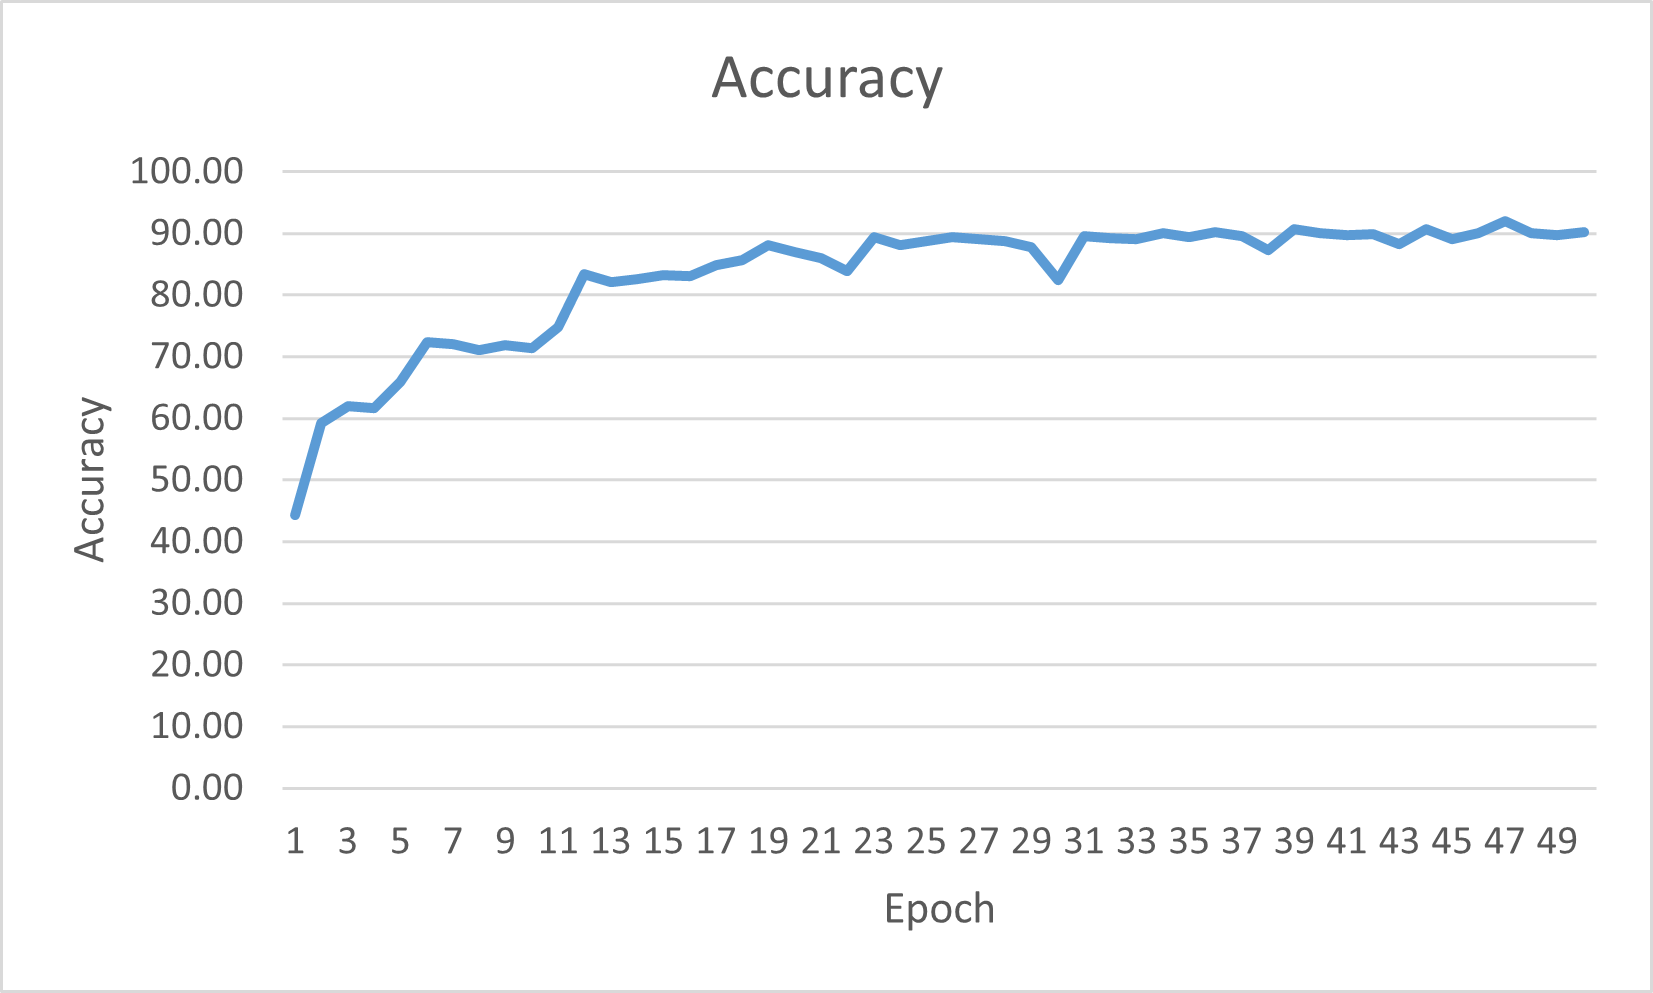
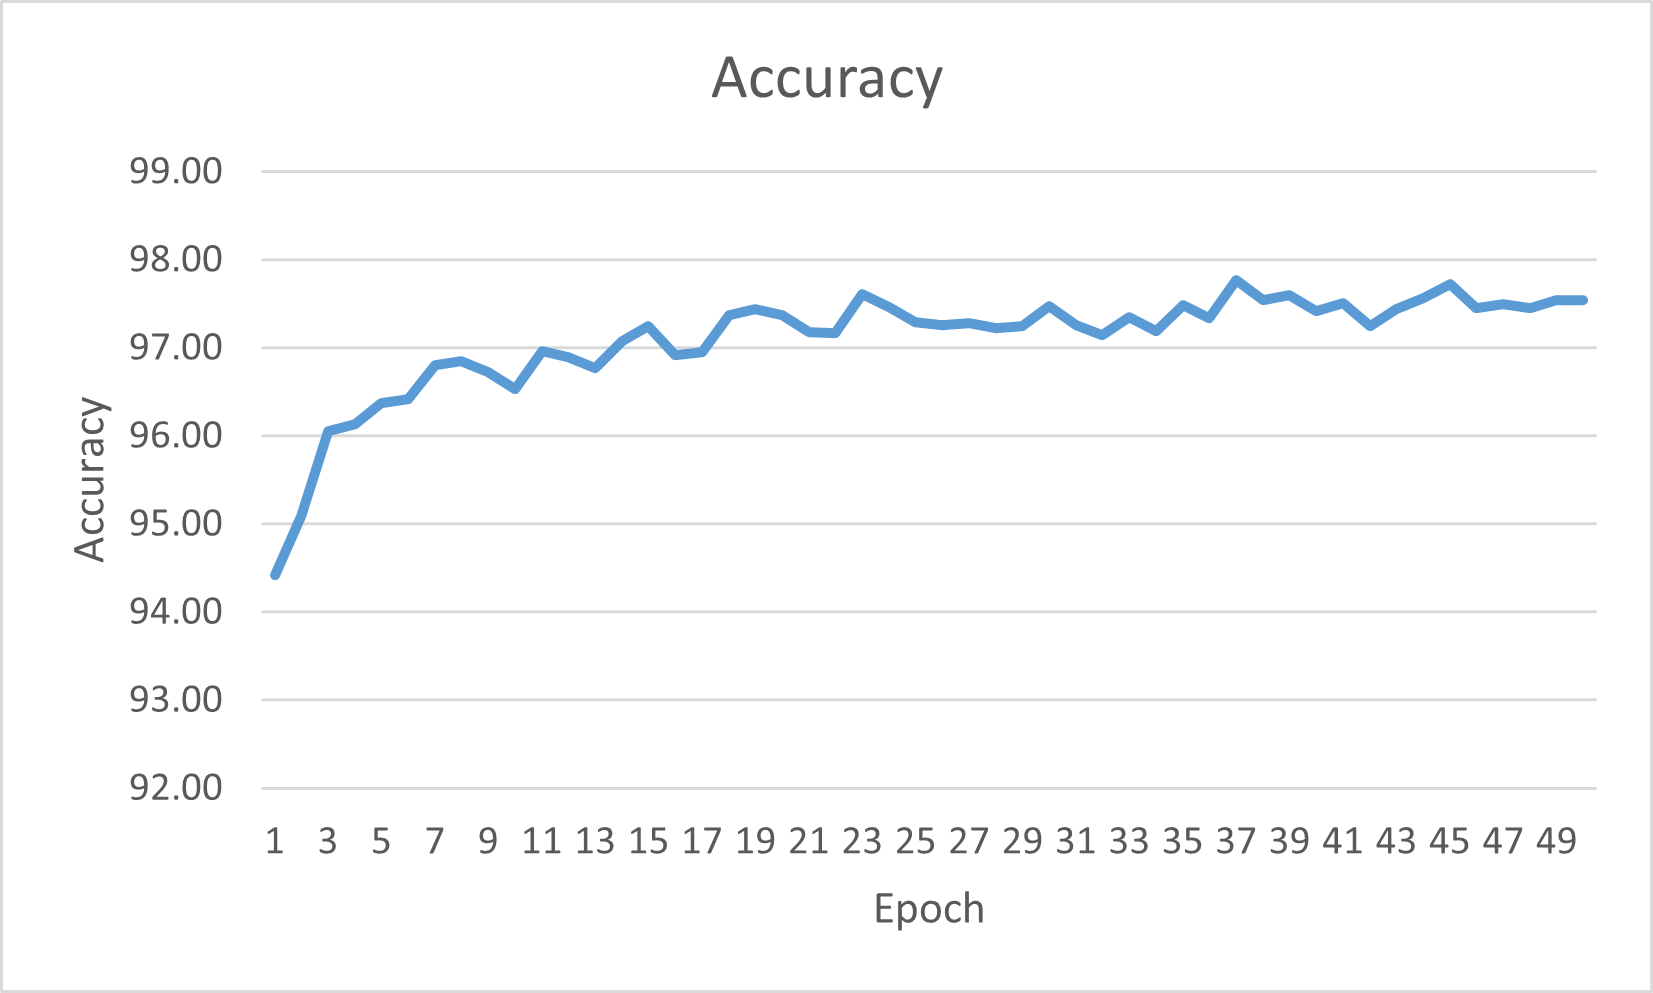

# Conclusion

We learned several things from this Kaggle challenge. We first created a numpy implementation of a neural network, to show our understanding of forward feeding and backpropagation, and learned how complicated a base implementation can be. We then went to PyTorch and experimented with different architecture choices, seeing how they affected accuracy over testing epochs. Finally, we tuned our model, only to discover that we had overtuned to our test set.

Further work could include experimenting with more architecture choices: we stuck with dropout layers and batch/layer norm layers, but there are many other architectural options we could use, such as convolution, res nets, or gradient clipping. We could experiment with other data normalization types - we stuck with min max scaling the entire time, but that may not be the best choice. Finally, we could try adding more hidden layers, increasing the model's complexity, as well as using different activation functions.